# Tutorial for batch processing in `expsolve`

We illustrate this with `expsolve.fourier`, which is imported as `ex`.

Batch processing is built-in in `expsolve` from ground up. This notebook demonstrates how to use it in practice.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, cos, abs, real, imag, pi
from torch.linalg import matrix_exp

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

### 2D example

We *need* to test this too!

In [21]:
n = [50, 50]
xr = [-10, 10]
[x,y] = ex.grid(n, xr)

V = x**4 + y**4 - 5*x**2 - 5*y**2

def ugen2D(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    y0 = np.random.normal(loc=0, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0x = np.random.normal(loc=0, scale=sw0)
    w0y = np.random.normal(loc=0, scale=sw0)

    u = exp(-((x-x0)**2 + (y-y0)**2)/(2*var)) * exp(1j*pi*w0x*(x-x0)) * exp(1j*pi*w0y*(y-y0))    
    u = ex.normalize(u, xr)
    return u

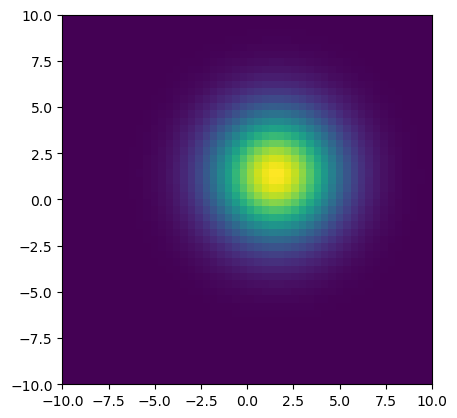

In [22]:
u = ugen2D(sx0=3.0, svar=2.0, sw0=1.0)
ex.imshow(plt, xr, abs(u))
plt.show()

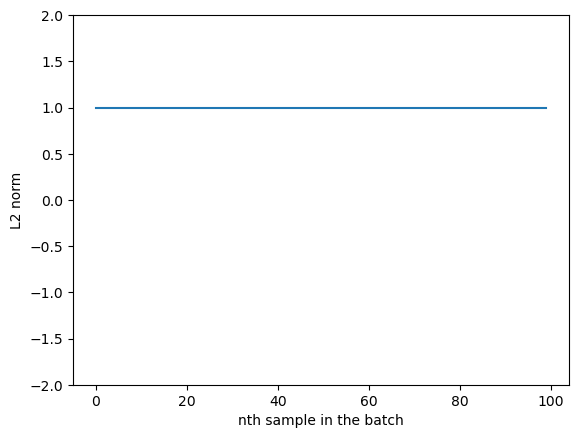

In [23]:
N = 100
urlist = [ugen2D(sx0=3.0, svar=2.0, sw0=1.0).squeeze(dim=0) for _ in range(N)]
urtensor = torch.stack(urlist) 

plt.plot(ex.l2norm(urtensor, xr).cpu())
plt.ylabel('L2 norm')
plt.xlabel('nth sample in the batch')
plt.ylim([-2,2])
plt.show()

In [24]:
#v = V.to(device)
eL1u = lambda h, c, u: ex.diffopexp(0, 2, 1j*h, u, xr) 
eL2u = lambda h, c, u: ex.diffopexp(1, 2, 1j*h, u, xr)

eLu = lambda t, tauV, h, c, u: eL1u(h, c, eL2u(h, c, u)) 
eVu = lambda t, tauL, h, c, u: exp(-1j*c*h*V)*u

strangalpha, strangbeta = split.symmetric([],[])
print(strangalpha, strangbeta)

strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

tensor([0.5000, 0.5000], dtype=torch.float64) tensor([1., 0.], dtype=torch.float64)


In [25]:
Nstep = 200
timegrid = es.timegrid(T, Nstep)

observables = {'energy': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) -ex.diffop(1, 2, psi, xr) + V*psi, u, xr), 
'position x': lambda u: ex.observable(lambda psi: x*psi, u, xr), 
'position y': lambda u: ex.observable(lambda psi: y*psi, u, xr), 
'momentum x': lambda u: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'momentum y': lambda u: ex.observable(lambda psi: 1j*ex.diffop(1, 1, psi, xr), u, xr), 
'kinetic': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) -ex.diffop(1, 2, psi, xr), u, xr), 
'potential':lambda u: ex.observable(lambda psi: V*psi, u, xr)}

In [26]:
T = 1.

tim1 = time.time()
uTbatch, obsvalues_batch, uintermediate_batch = es.solvediffeq(urtensor, timegrid, strangstep, observables=observables)
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {N} took {tim_batch}s')


tim1 = time.time()
for ur in urlist:
    ustrangTloop = es.solvediffeq(ur.unsqueeze(dim=0), timegrid, strangstep, observables=observables)[0]
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {N} took {tim_loop}s')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')

Batch of size 100 took 15.082503080368042s
Loop of size 100 took 87.9662697315216s
Speed up factor 5.83 on cpu


Speedup is expected to be more when each problem itself is small, and the number of batches large. For high dimensional problems, this reduces the speedup from batch operations. The exact level at which speedup becomes limited depends on the CPU/GPU architecture heavily, of course.

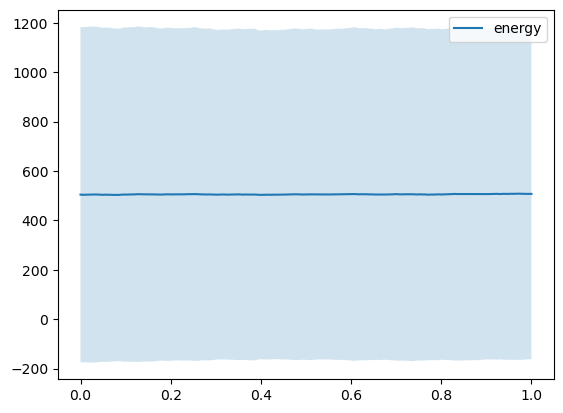

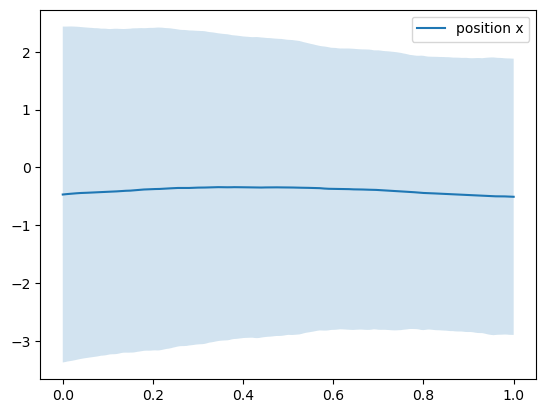

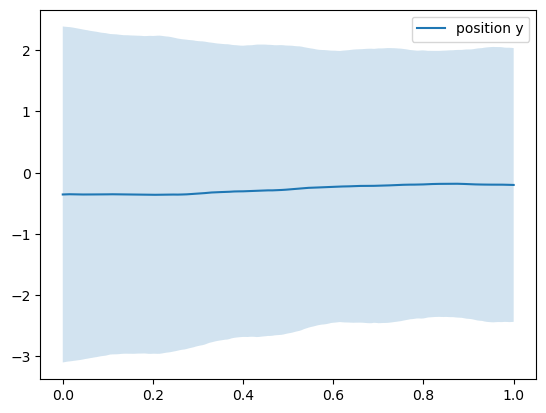

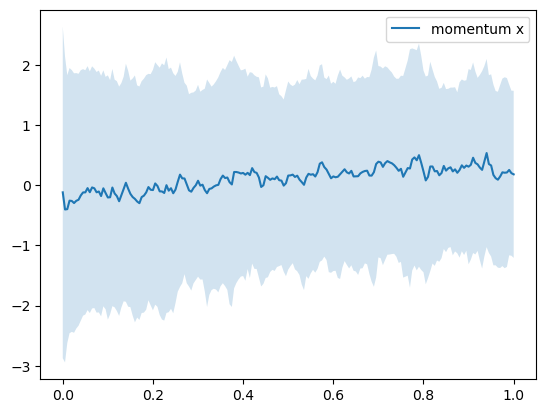

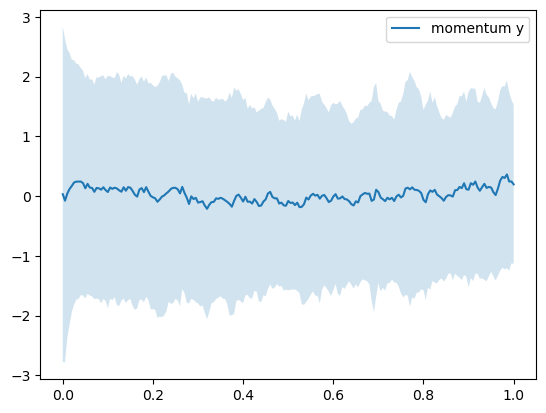

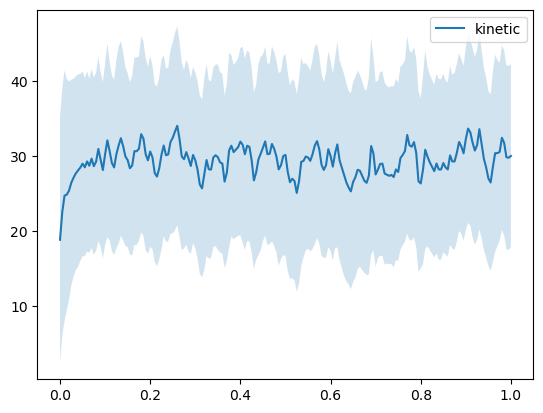

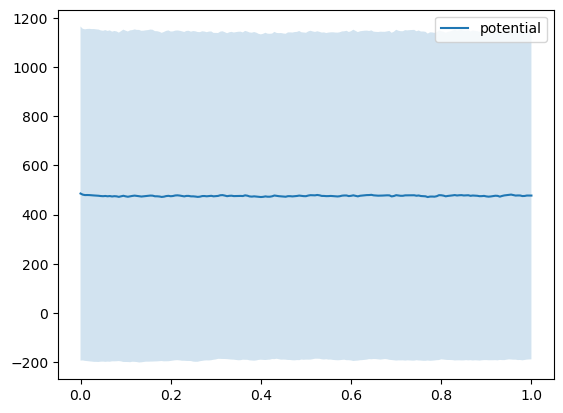

In [27]:
for o in observables:
    ov = obsvalues_batch[o]
    plt.figure()
    ex.plot(plt, timegrid, ov)   
    plt.legend([o])
    plt.show()